## Rappel Google Colab

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. 
Installer ensuite deeplib avec la commande suivante:

In [ ]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

# Laboratoire 6: Réseaux de neurones récurrents

### Références
Ce laboratoire est une adaptation du tutoriel sur les réseaux de neurones récurrents créé par **Jean-Philippe Reid** (jean.philippe.reid@rd.mila.quebec) dans le cadre de l'école d'hiver IVADO/MILA en apprentissage profond 2018.

Lien vers le tutoriel original : https://github.com/mila-udem/ecolehiver2018/blob/master/Tutoriaux/Hiver18_0308_tutorial_rnn_lstm_solution.ipynb

Autres références:
* http://colah.github.io/posts/2015-08-Understanding-LSTMs/
* https://distill.pub/2016/augmented-rnns/

In [1]:
%load_ext autoreload
%autoreload 2

from random import randint
import numpy as np
from time import time

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset

import poutyne as pt
from deeplib.training import train, test, get_model

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

torch.manual_seed(42)

## Partie 1: Définition de la tâche

L'objectif de ce laboratoire est de construire un modèle capable d'additionner ou soustraire une série de nombres. Ce jeu de données est facile à générer et nous permet de tester la capacité des réseaux de neurones récurrents.

Le jeu de données est constitué d'une séquence de nombre de longueurs *seq_len* , à laquelle une cible est associée. Dans l'exemple ci-dessous, la i$^{ème}$ composante des données est explicitement détaillée (voir la Figure 1). 

\begin{align}  
\mathrm x^{(i)} &= \left[ 4,-1,15,24\right], \mathrm x^{(i)} \in \mathbb R^{d_0} \\ 
\mathrm y^{(i)} &= 42, \mathrm y^{(i)} \in \mathbb R 
\end{align}

Il est important de noter que chaque composante du vecteur $\mathrm x^{(i)}$, peut être de plusieurs dimensions, c'est-à-dire $x^{(i)}_j \in \mathbb R^{d_1}$ où $d_1 > 1$. 


Ce jeu de données peut ainsi servir à entraîner un modèle de réseau de neurones récurrents (RNN), tel que le _long short term memory_ (LSTM). Dans ce cas, chaque nombre sera l'entrée d'une couche cachée (_hidden layer_) de dimension $h_d$. 

Comme la cible est un nombre réel, il est nécessaire de d'ajouter une couche linéaire au modèle pour "ajuster" les dimensions (voir la Figure 2). Cette notion sera expliquée à l'aide d'un exemple détaillé ci-bas. 

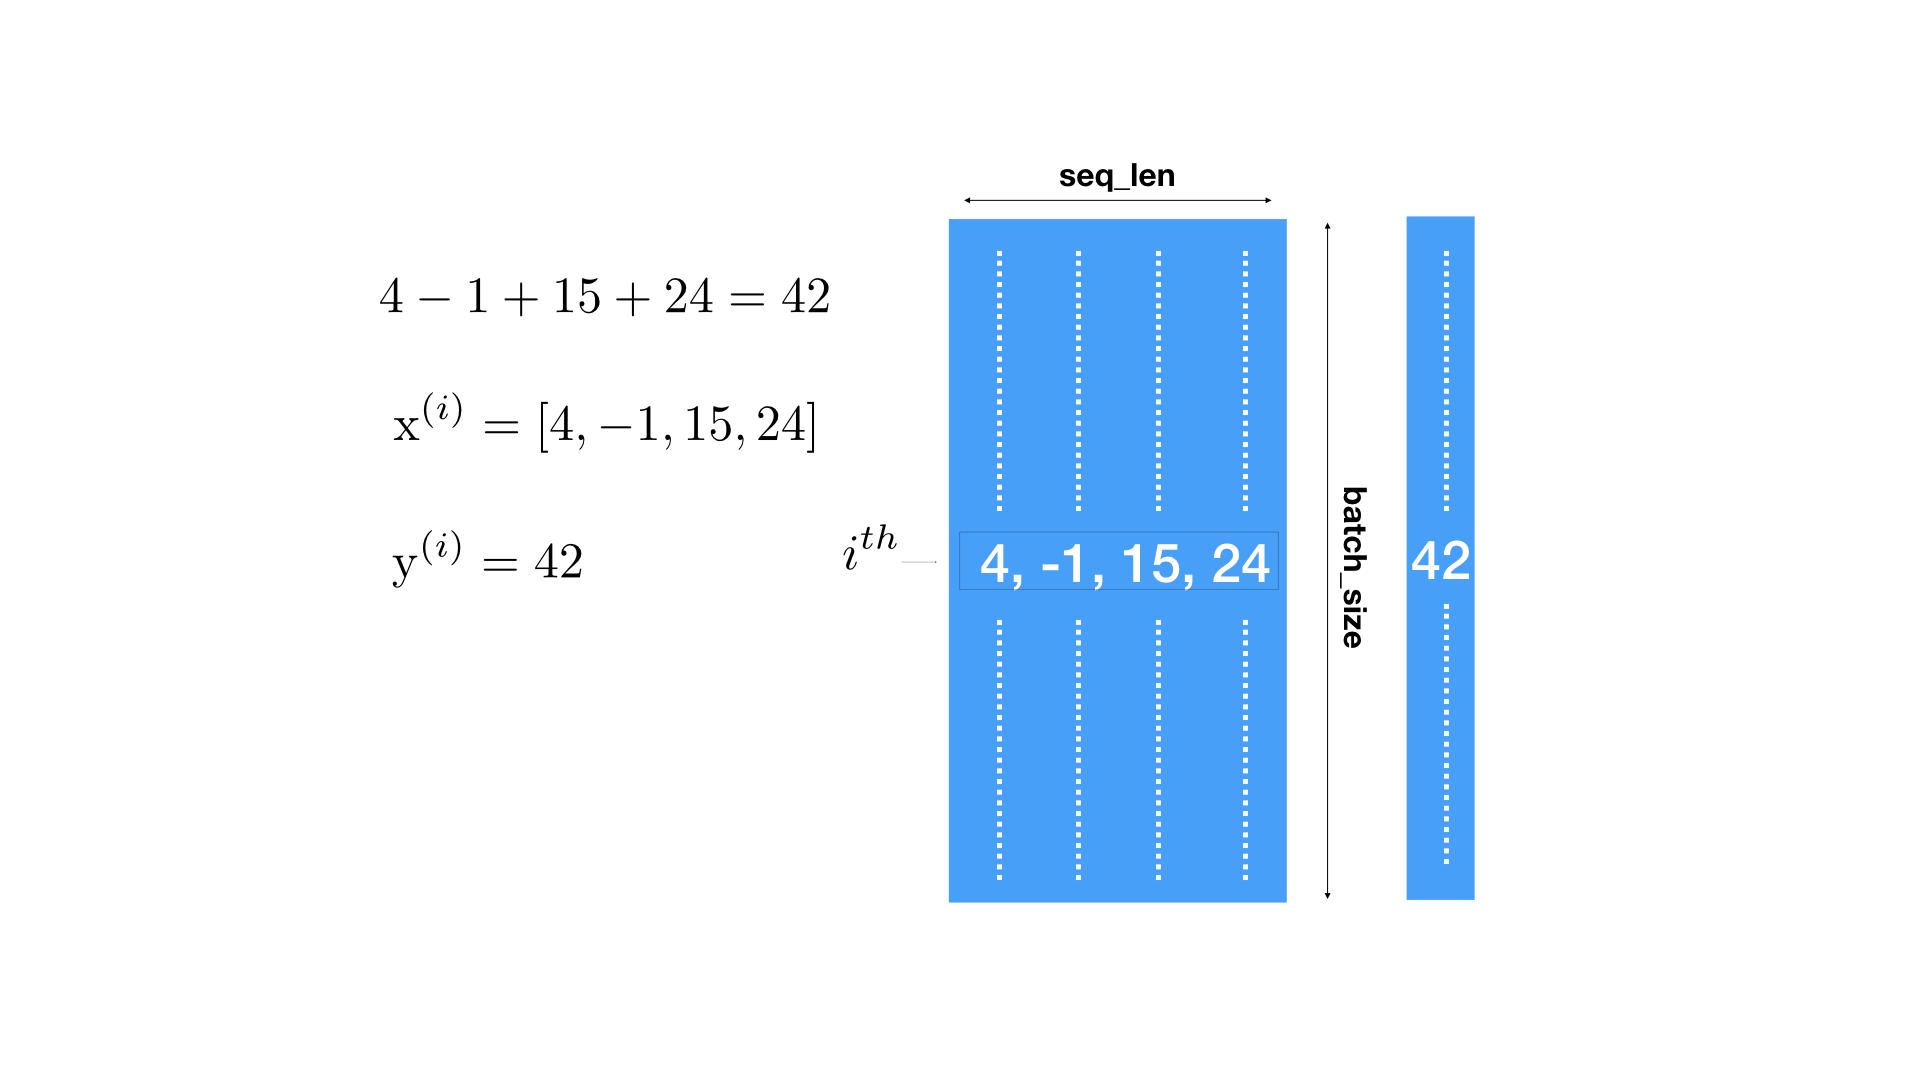

<div align="center">
  Figure 1 : Jeu de données considéré. 
</div>

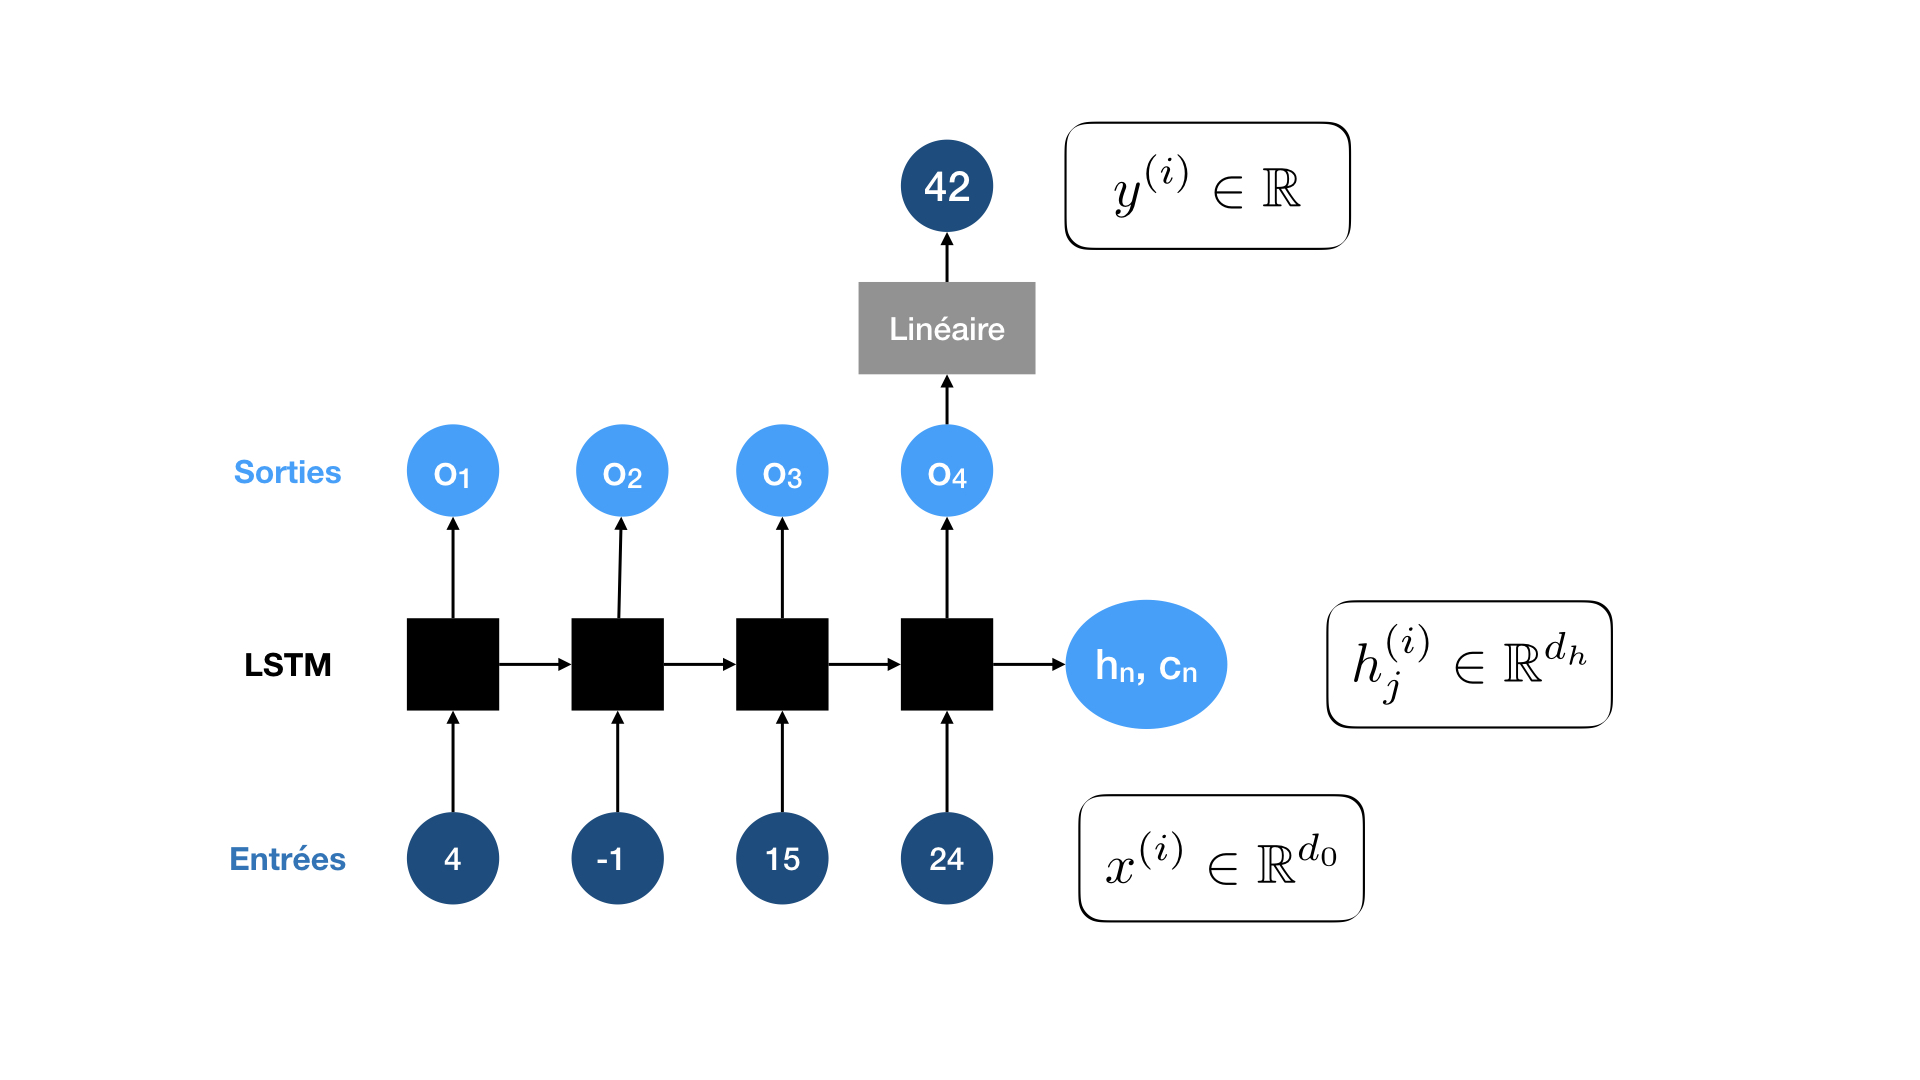

<div align="center">
  Figure 2 : Schéma d'un réseau récurrent. 
</div>

## Partie 2: Réseau de neurones récurrent (LSTM)

Explorons maintenant comment utiliser l'implémentation PyTorch d'un [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM).

### Générer une couche LSTM

__<font color='red'>lstm</font> = nn.LSTM(input_size, hidden_size, num_layers)__

Une couche LSTM peut incorporer plusieurs paramètres dont certains régis par le jeu de données (*input_size*), mais aussi d'autres paramètres essentiels pour optimiser la capacité du modèle, tels que *hidden_size*, *num_layers*, etc.

> **Attention: lorsque *batch_first=True*, l'ordre des dimensions *batch_size*, *seq_len* est inversé.**

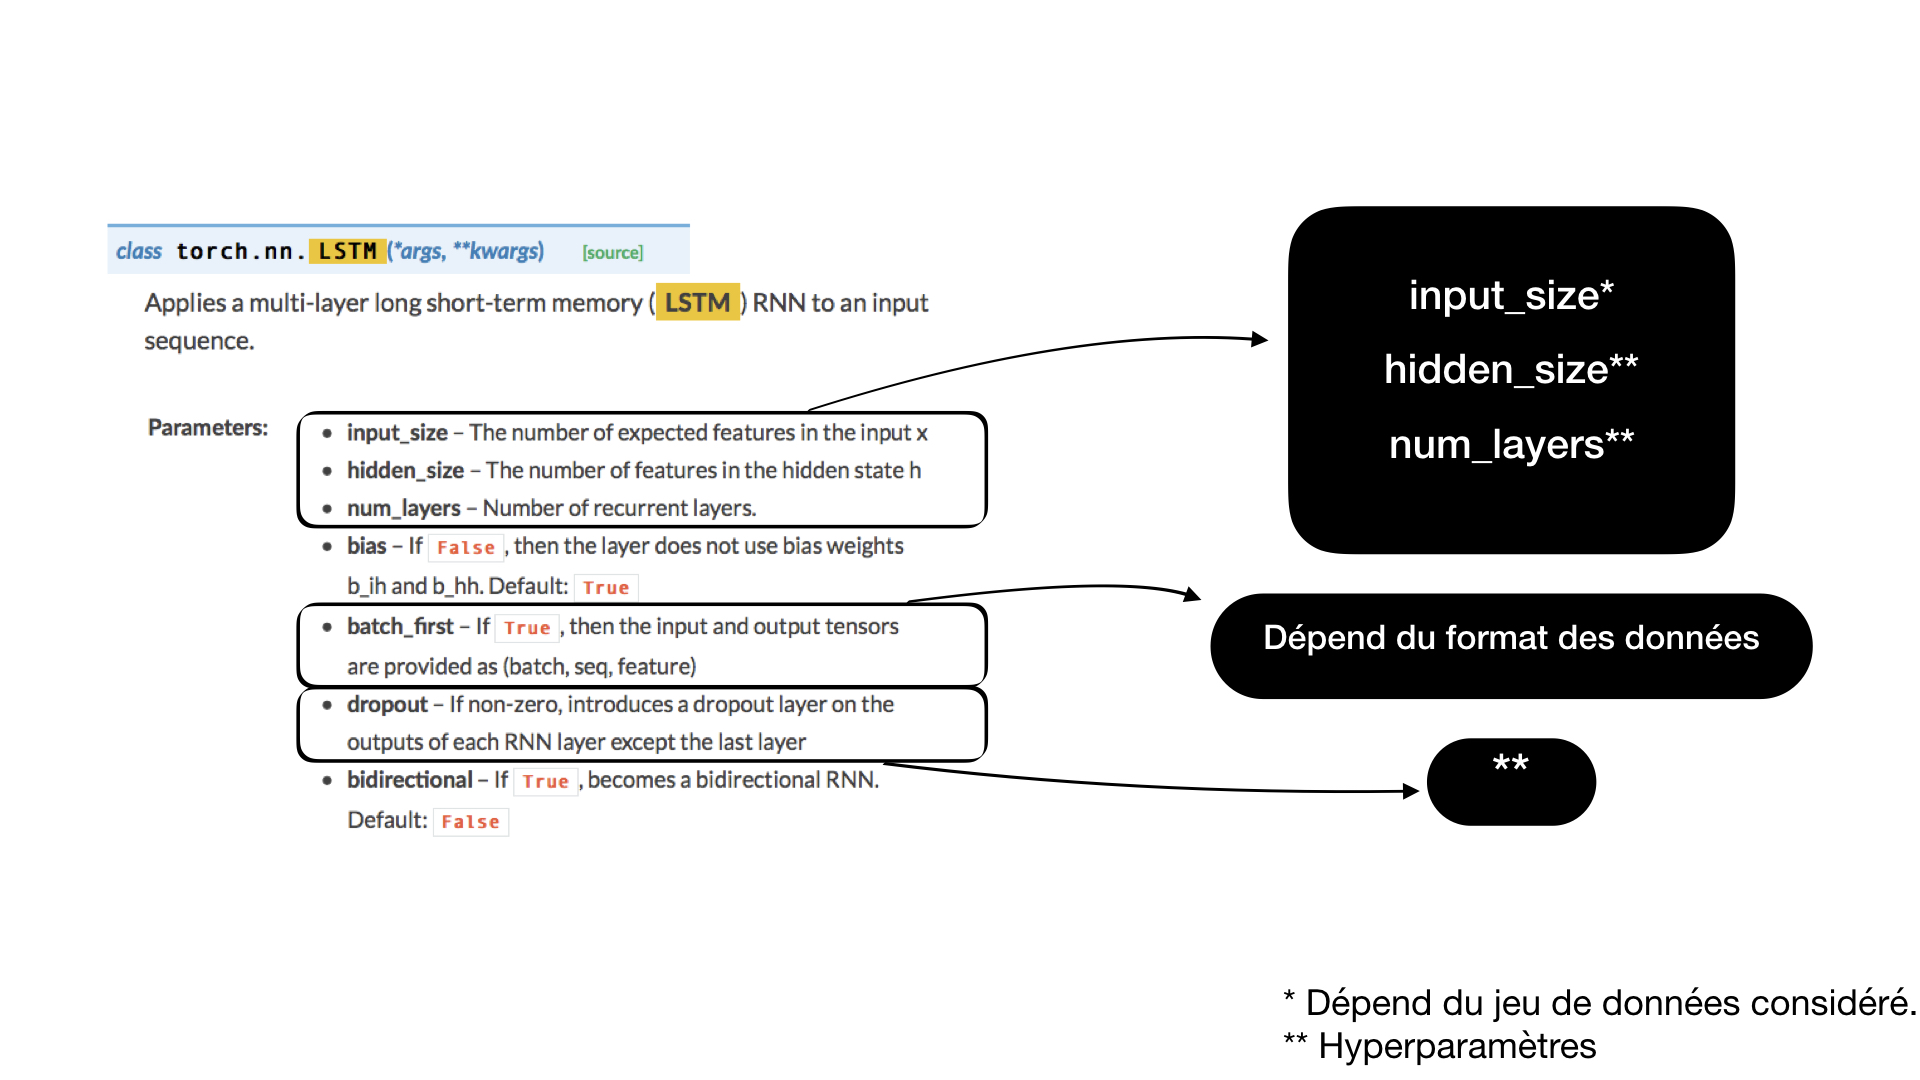

<div align="center">
  Figure 3 : couche LSTM. 
</div>

### Entrées d'une couche LSTM (*inputs*)
____ = <font color='red'>lstm</font>(<font color='blue'>input</font>, (h0,c0))__

En plus des données (_input_), il est aussi possible d'initialiser les tenseurs h_0, c_0 définis comme les *hidden* et *cell states*,  paramètres essentiels aux LSTMs. 

> __Dans le cas où $h_0$ et $c_0$ ne sont pas définis, le module LSTM utilisera les valeurs par défaut, i.e. 0.__

### Donnée d'entrée (*input*)
__<font color='blue'>input</font> =  torch.Tensor(seq_len, batch_size, input_size)__

Il est nécessaire de réorganiser les données d'entrées (input) selon trois paramètres : 

* la longueur de la séquence (seq_len)
* la grandeur du lot (batch, i.e. batch_size)
* les dimensions des entrées (input_size)

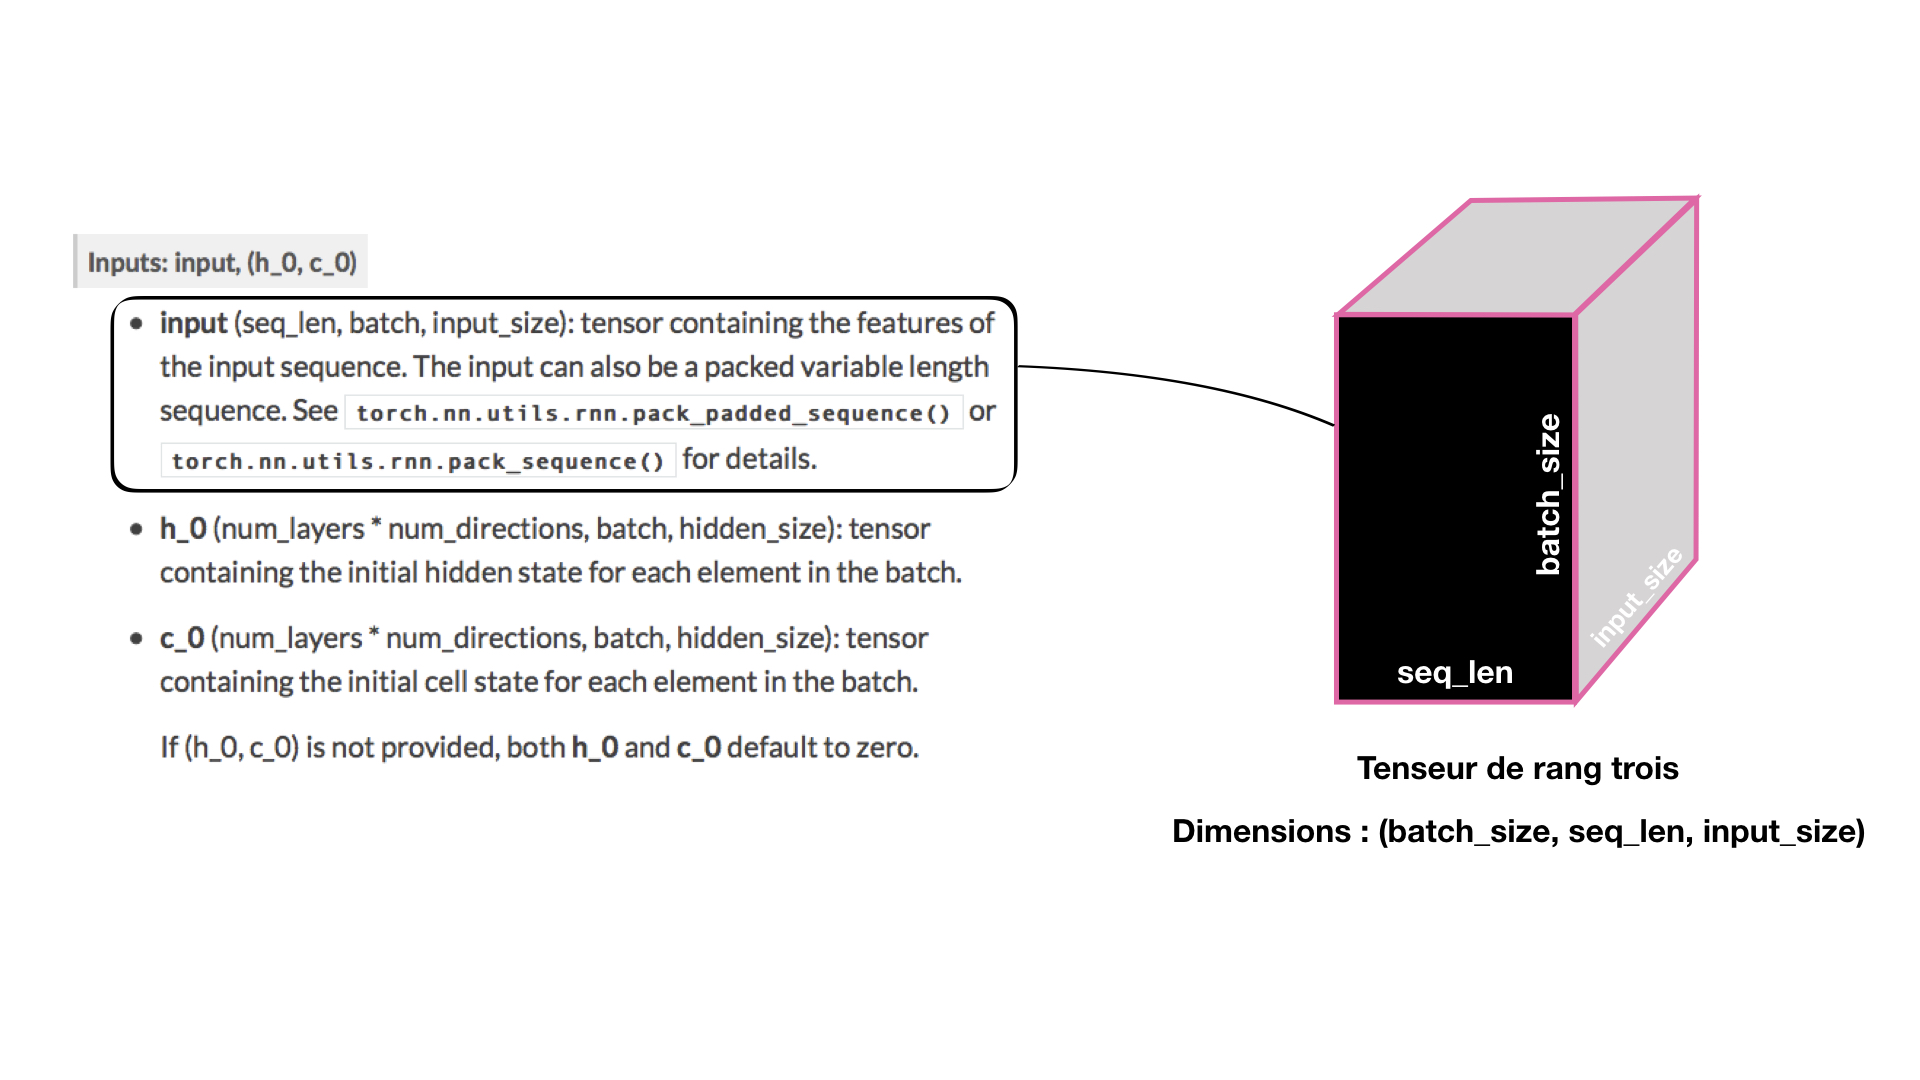

<div align="center">
  Figure 4 : Entrée d'une couche LSTM (le schéma à droite considère <i>batch_first=True</i>). 
</div>

### Donnée de sortie (*output*)

__<font color='green'>output</font> = <font color='red'>lstm</font>(<font color='blue'>input</font>, (h0,c0))__

Les dimensions du tenseur <font color='green'>output</font> sont déterminées par: (*seq_len*, *batch*, *hidden_size* $\times$ *num_directions*). 

Dans le cas qui nous intéresse, num_directions $ = 1$, car nous ne considérons pas un LSTM bidirectionnel. 

__<font color='green'>output</font> = torch.tensor(seq_len, batch_size, hidden_size x num_directions)__

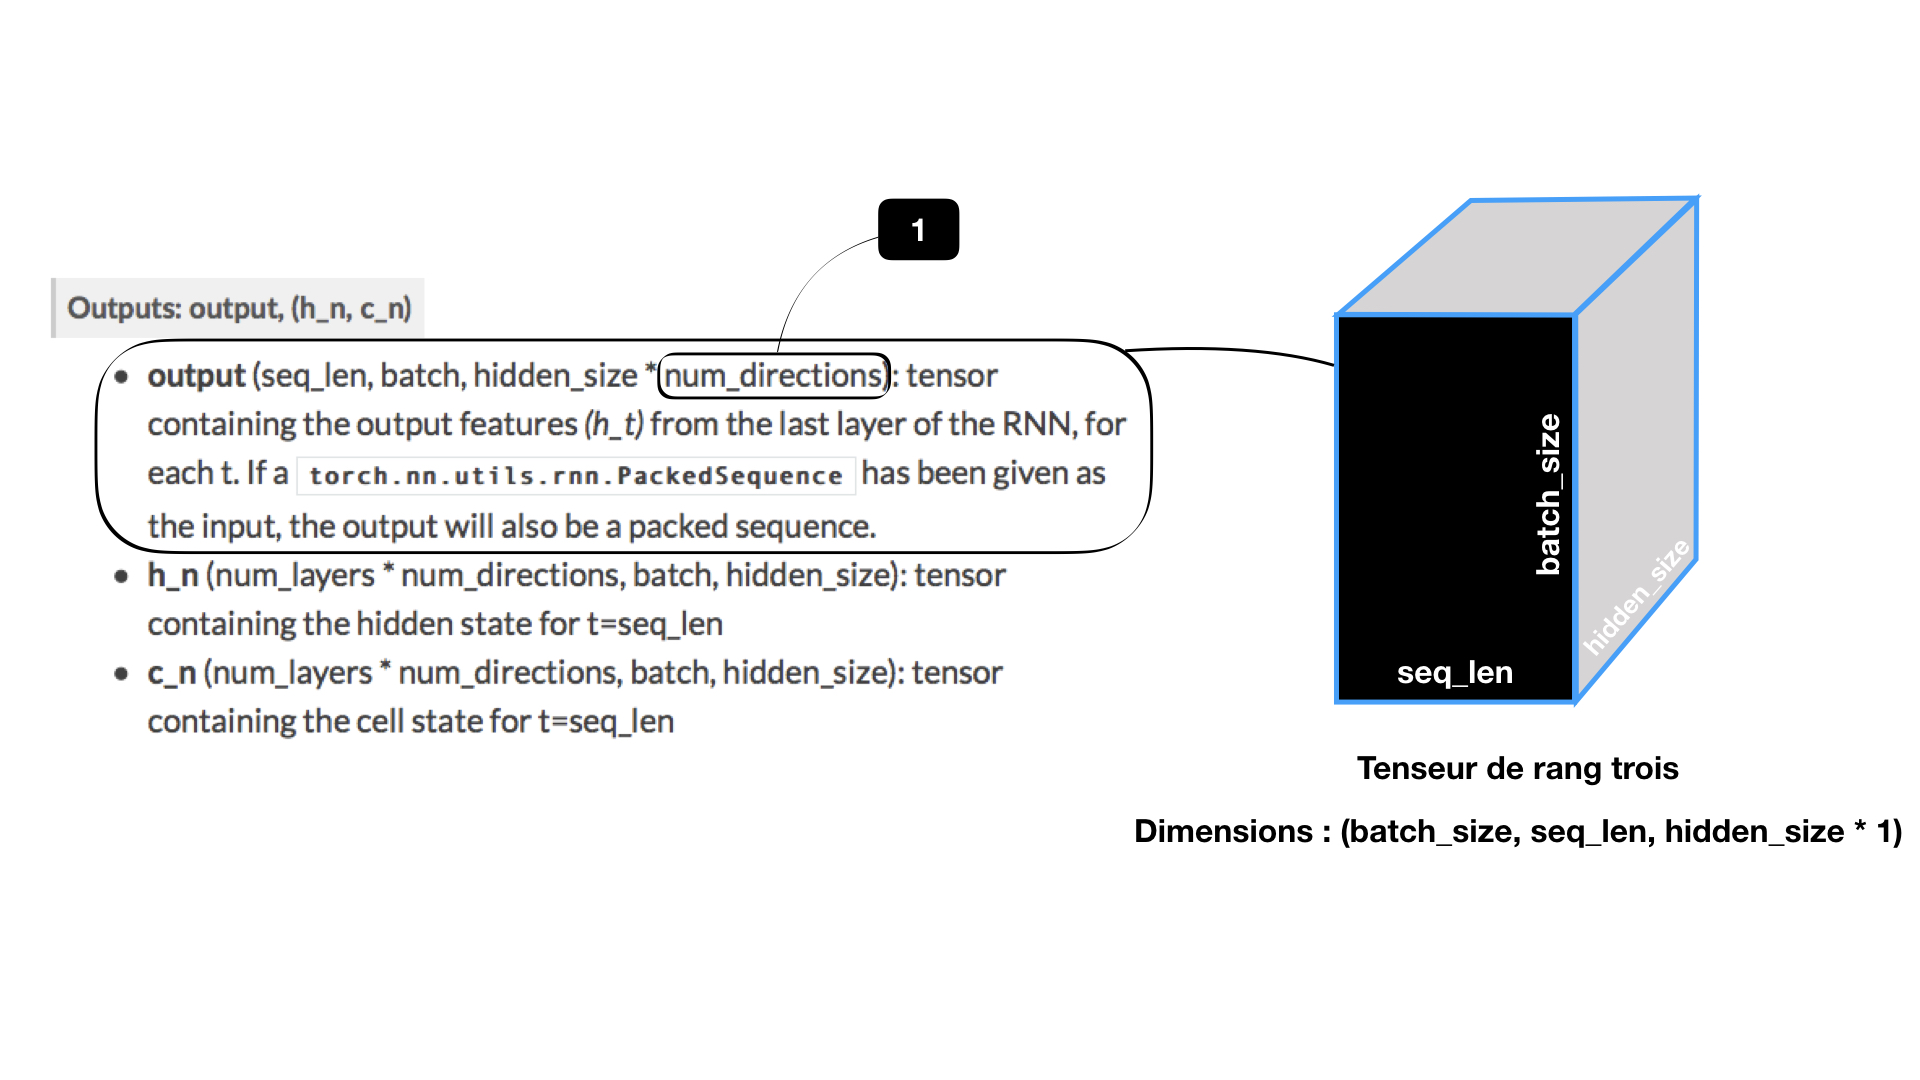

<div align="center">
  Figure 5 : Sortie d'une couche LSTM (le schéma à droite considère <i>batch_first=True</i>). 
</div>

# Partie 2.1: Préliminaires

Créons un jeu de données $\bf x$ composés de 100 séquences de 4 nombres entre 0 et 100. Les cibles $\bf y$ correspondent à la somme de chacune de ces séquences. La fonction `build_sum_dataset` s'occupe de cette tâche. 

In [2]:
def build_sum_dataset(N, T, interval):
    ''' 
    inputs : 
    N : nombre de données 
    T : longueur de la séquence
    interval : l'intervalle dans lequel les nombres seront tirés pour générer les séquences. 
    
    outputs: retourne les séquences (xx) et les cibles (yy), en format torch.tensor 
    '''
    x = torch.Tensor(N, T).random_(interval[0], interval[1] + 1)
   
    return x, x.sum(dim=1)

In [3]:
# Création d'un jeu de données 
x, y = build_sum_dataset(100, 4, [-100, 100])

print('Dimensions des entrées : {} x {}'.format(*x.shape))

Dimensions des entrées : 100 x 4


La fonction `print_sequence` permet de visualiser un exemple du jeu de données: la séquence de nombres et la somme résultante.

In [4]:
def print_sequence(x, y):
    '''
    x : Une séquence particulière, i.e dim(x) = 1 x T
    y : Cible liée à cette même séquence, i.e. dim(y) = 1
    retourne une série de caractères illustrant la séquence 
    dans un format convivial. 
    '''
    
    string = ' + '.join(["{:.0f}".format(n) for n in x])
    print(string + ' = ' + "{:.0f}".format(y))

In [5]:
print_sequence(x[1,:] ,y[1])

83 + 1 + -12 + -68 = 4


#### Question
- Selon l'exemple ci-haut, quels sont les paramètres d'entrées? On considéra ici qu'un seul lot (*batch*). 

    **batch_size = 100**

    **seq_len = 4**
    
    **input_size = 1**

In [6]:
# TODO
# batch_size = ...
# seq_len = ...
# input_size = ...

batch_size = x.shape[0]
seq_len = x.shape[1]
input_size = 1

print('batch_size = {}, seq_len = {}, input_size = {}'.format(batch_size, seq_len, input_size))

batch_size = 100, seq_len = 4, input_size = 1


#### Question
- Donnez un exemple où les dimensions d'entrées sont supérieures à un, c.-à-d. *input_size* $> 1$. 

    **Une phrase correspond une séquence de mots, où chaque mot est représenté par un *one hot* vecteur de dimension égale à la grandeur du vocabulaire. Avec un dictionnaire de taille 60000, on a donc un *input_size* = 60 000.**

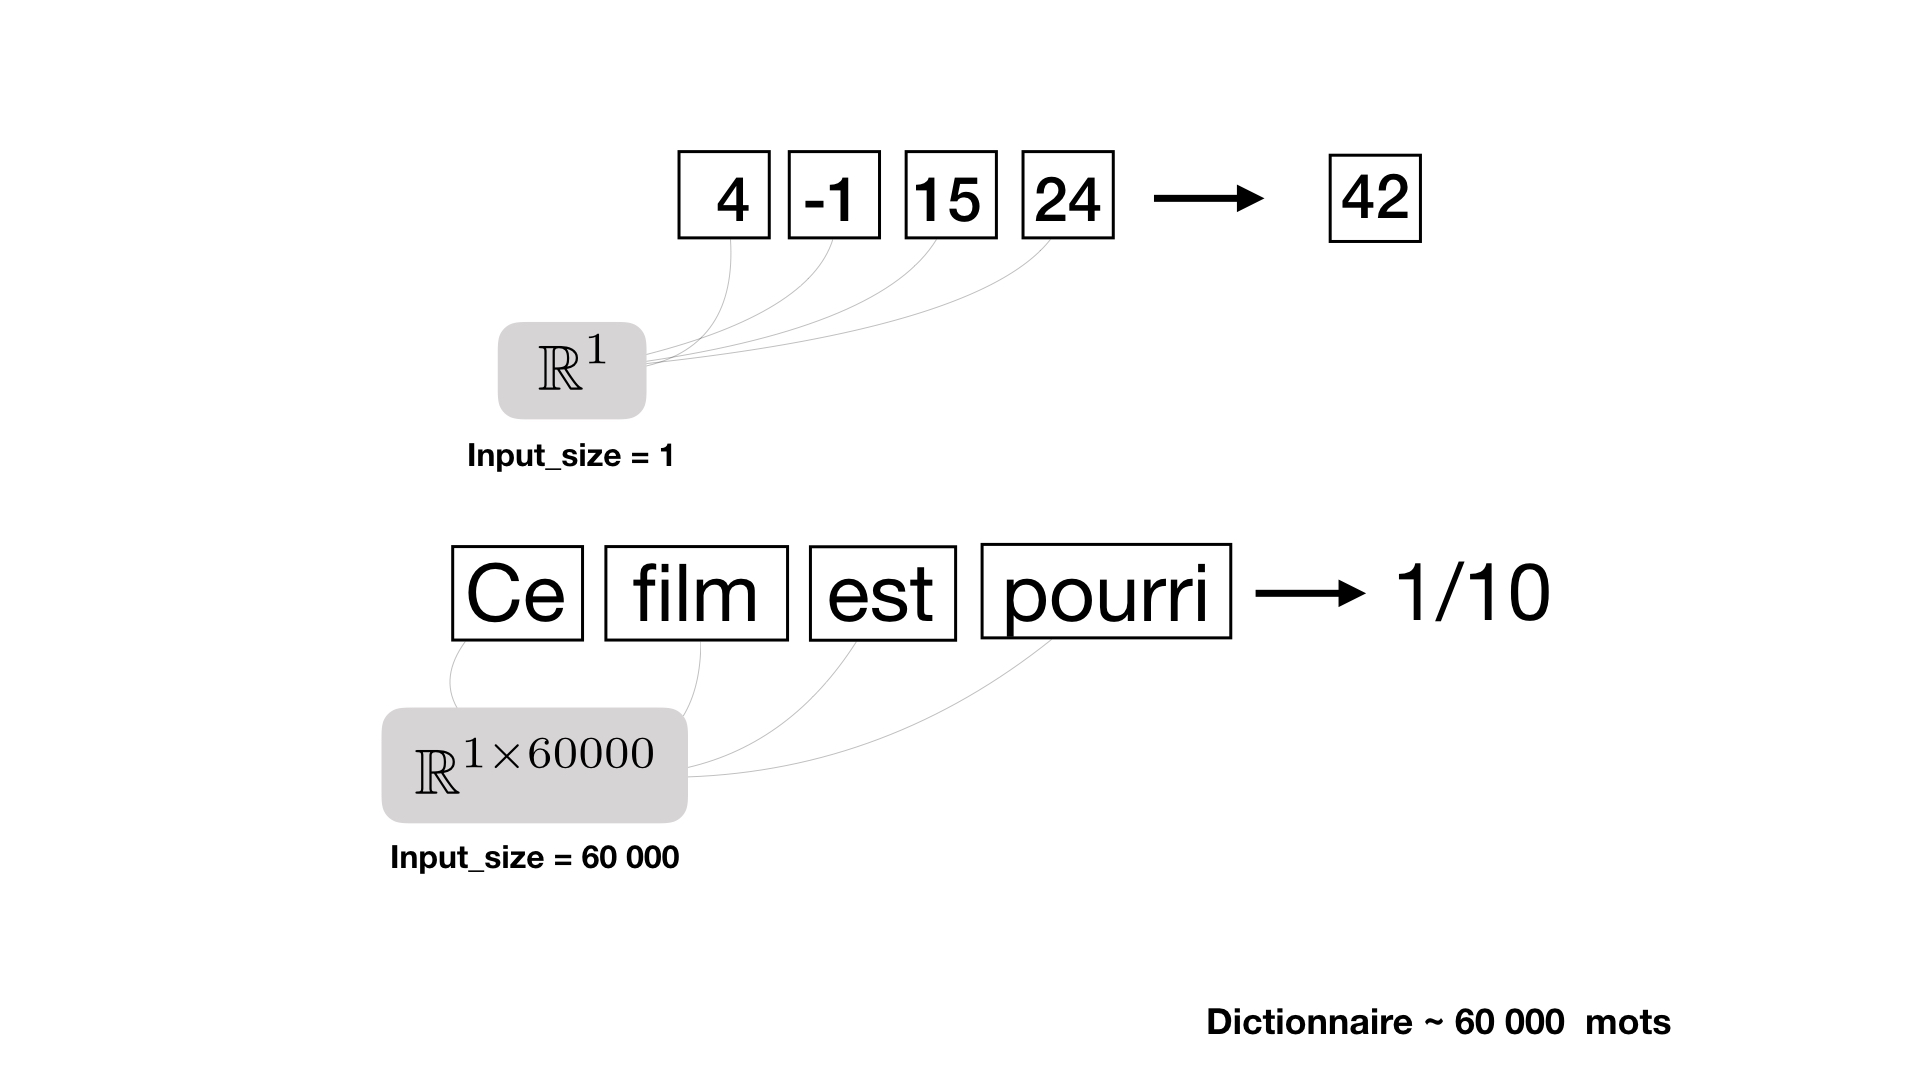

Notez que 1/10 correspond à l'analyse de sentiment du commentaire. Une note de 1/10 représente un commentaire négatif alors que 10/10 correspond à un commentaire très positif.

#### Exercice
- Construisez votre première couche LSTM selon les paramètres fournis ainsi qu'avec `batch_first=True`. Référez-vous à la Figure 3 pour vous aider.

In [7]:
# Paramètres
input_size = 1
hidden_size = 6
num_layers = 1

# TODO
# lstm = ...
lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)

# On explicite la dimensions des données car input_size = 1.
x_ = x[:, :, np.newaxis]
y_ = y[:, np.newaxis]

# forward 
output, (hn, cn) = lstm(x_)

print('Dimensions - output: {}'.format(output.shape))
print('Dimensions - h_n: {}'.format(hn.shape))
print('Dimensions - c_n: {}'.format(cn.shape))

Dimensions - output: torch.Size([100, 4, 6])
Dimensions - h_n: torch.Size([1, 100, 6])
Dimensions - c_n: torch.Size([1, 100, 6])


### Réorganiser les dimensions de la sortie ("<font color='green'>output</font>") 

Seule la dernière composante du tenseur <font color='green'>output</font> sera considérée pour prédire la cible associée à une séquence, voir la Figure 2 où la composante $o_4$ est utilisée pour faire la prédiction avec une couche linéaire. 

Exemple: considérons la $41^e$ séquence,

In [8]:
print_sequence(x[41],y[41])

66 + -95 + 25 + -65 = -69


ainsi que la sortie associée. 

In [9]:
print(output[41,:,:])
print(output[41,:,:].shape)

tensor([[ 4.3665e-12,  1.3301e-08,  1.2096e-01, -4.5656e-05, -2.2698e-12,
          2.0631e-11],
        [-7.6147e-01,  7.6159e-01,  5.6574e-01,  8.0896e-02,  7.6114e-01,
         -1.0829e-10],
        [ 2.6521e-05,  9.6939e-04,  1.8886e-01, -1.5688e-02,  1.0841e-05,
         -1.3279e-02],
        [-7.5291e-01,  7.6392e-01,  3.5611e-01,  1.3493e-01,  7.6615e-01,
         -1.5383e-07]], grad_fn=<SliceBackward>)
torch.Size([4, 6])


Tel que mentionné ci-haut, seule la quatrième (dernière) composante du tenseur <font color='green'>output</font> doit être considérée (voir Figure 2).

In [10]:
output[41,-1,:]

tensor([-7.5291e-01,  7.6392e-01,  3.5611e-01,  1.3493e-01,  7.6615e-01,
        -1.5383e-07], grad_fn=<SliceBackward>)

De manière plus pratique, le tenseur $h_n$ retourné également par le *forward* de la couche *lstm* regroupe  déjà la dernière sortie (*output*) de chaque séquence.

In [11]:
print(hn[:,41,:])

tensor([[-7.5291e-01,  7.6392e-01,  3.5611e-01,  1.3493e-01,  7.6615e-01,
         -1.5383e-07]], grad_fn=<SliceBackward>)


> **Attention: $h_n \neq $ <font color='green'>output</font>$[:, -1, :]$ dans des cas plus complexes comme par exemple lors de l'utilisation de packed sequences, avec un lstm bidirectionnel, lorsque *num_layers* $> 1$, etc.**

#### Exercice
- Proposez une stratégie pour transformer le tenseur <font color='green'>output</font>  de dimensions [100,4,6] en un tenseur de prédictions de dimensions voulues, c.-à-d. [100,1]. Spécifiquement, quelle opération mathématique avec un tenseur *M* permettra d'obtenir les dimensions voulues?

    **Il faut effectuer un produit tensoriel entre la dernière composante du tenseur <font color='green'>output</font> et un tenseur *M* de dimensions [*hidden_size*, 1].**

In [12]:
# TODO
# M = torch.Tensor(...)
M = torch.Tensor(hidden_size, 1)
# prediction = ...
prediction = torch.matmul(output[:, -1, :], M)
# TODO END
print(prediction.shape)

torch.Size([100, 1])


- Générez maintenant le vecteur de prédictions en utilisant plutôt une couche linéaire comme dans la Figure 2.

In [13]:
# TODO
# linear = ...
linear = nn.Linear(hidden_size, input_size, bias=True)
# prediction = ...
prediction_output = linear(output[:,-1,:])
print(prediction_output.shape)

torch.Size([100, 1])


- Effectuez la prédiction avec la couche linéaire en utilisant le vecteur $h_n$ cette fois.

In [14]:
# TODO
# prediction = ...
prediction_hn = linear(hn)
print("La prédiction avec hn est égale à celle avec output[:,-1,:]:",
      torch.allclose(prediction_output, prediction_hn))

La prédiction avec hn est égale à celle avec output[:,-1,:]: True


### Construction du modèle

#### Exercice
- Complétez la fonction `forward` du module RnnLinear. Cette fonction aura en entrée le tenseur $\bf x$ de dimension *batch_size* x *hidden_size* x 1. 

In [15]:
class RnnLinear(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, lstm_or_rnn):
        '''
        Les paramètres importants du modèle sont définies dans cette fonction. 
        '''
        num_directions = 1
        super(RnnLinear, self).__init__()
        
        # parametres importants 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm_or_rnn = lstm_or_rnn      
        
        # couches de notre réseau 
        if lstm_or_rnn == 'lstm':
            self.lstm = nn.LSTM(input_size, hidden_size, 
                                num_layers, dropout = 0.5,
                                batch_first = True) 
              
        elif lstm_or_rnn == 'rnn':
            self.rnn = nn.RNN(input_size, hidden_size,
                              num_layers, dropout = 0.5, 
                              batch_first = True
                             )
              
        else: print('You made a mistake, pal!')
        
        self.linear = nn.Linear(hidden_size, input_size, bias=True)

    def forward(self,x):
        '''
        La sortie des couches LSTM et RNN est l'entrée
        de la couche linéaire. 
        '''
        # TODO
        # cas où self.lstm_or_rnn = 'rnn'
        if self.lstm_or_rnn == 'rnn':
            # out1,_ = ...
            # pass
            out1, hn = self.rnn(x)

        # cas où self.lstm_or_rnn = 'lstm'      
        if self.lstm_or_rnn == 'lstm':
            # out1,(_, _) = ...
            # pass
            out1, (hn, cn) = self.lstm(x)

        # votre couche linéraire             
        # out2 = ...
        # TODO END
        out2 = self.linear(out1[:,-1,:])
        
        '''
        # Autre solution valide 
        out2 = self.linear(hn[-1, :, :])
        '''

        return out2

Testez que votre modèle fonctionne bien.

In [16]:
x, y = build_sum_dataset(100, 4, [0, 100])

# Préparation des données d'entrée. 
x = x[:, :, None]
y = y[:, None]

input_size = 1
num_layers = 2
hidden_size = 40 

model = RnnLinear(input_size, hidden_size, num_layers, 'lstm')

print('Dimensions des données d\'entrée: {}'.format(x.shape))

pred = model(x)
print('Dimensions des prédictions : {}'.format(pred.shape))

Dimensions des données d'entrée: torch.Size([100, 4, 1])
Dimensions des prédictions : torch.Size([100, 1])


## Partie 2.2: Entraînement 

Effectuez l'entraînement d'un modèle sur 20 époques avec ces paramètres et hyperparamètres: 
* N = 20000
* seq_len = 10 
* intervalle = [-100,100]
* hidden_size = 20
* number_epoch = 20
* batch_size = 100
* lr = 0.05

Création du jeu de données

In [17]:
torch.manual_seed(42)
N = 20000
seq_len = 10
inter_max = 100

x, y = build_sum_dataset(N, seq_len, [-inter_max, inter_max])

#  standardisation des données pour faciliter l'apprentissage
x, y = x / inter_max, y / inter_max

# Préparation des données d'entrée. 
x = x[:, :, np.newaxis]
y = y[:, np.newaxis]

x_train, y_train = x[:15000], y[:15000]
x_test, y_test = x[15000:], y[15000:]

data_train = TensorDataset(x_train, y_train)
data_test = TensorDataset(x_test, y_test)

Entraînement du modèle

Epoch:  1/20 Step: 120/120 100.00% |████████████████████|1.11s loss: 3.047987 val_loss: 1.963631
Epoch:  2/20 Step: 120/120 100.00% |████████████████████|1.10s loss: 0.853932 val_loss: 0.643815
Epoch:  3/20 Step: 120/120 100.00% |████████████████████|1.09s loss: 0.467735 val_loss: 0.339129
Epoch:  4/20 Step: 120/120 100.00% |████████████████████|1.11s loss: 0.344886 val_loss: 0.352831
Epoch:  5/20 Step: 120/120 100.00% |████████████████████|1.07s loss: 0.281311 val_loss: 0.240951
Epoch:  6/20 Step: 120/120 100.00% |████████████████████|1.09s loss: 0.227041 val_loss: 0.280329
Epoch:  7/20 Step: 120/120 100.00% |████████████████████|1.08s loss: 0.183990 val_loss: 0.064675
Epoch:  8/20 Step: 120/120 100.00% |████████████████████|1.08s loss: 0.148869 val_loss: 0.165221
Epoch:  9/20 Step: 120/120 100.00% |████████████████████|1.09s loss: 0.136655 val_loss: 0.171496
Epoch: 10/20 Step: 120/120 100.00% |████████████████████|1.07s loss: 0.149386 val_loss: 0.035911
Epoch: 11/20 Step: 120/120 100

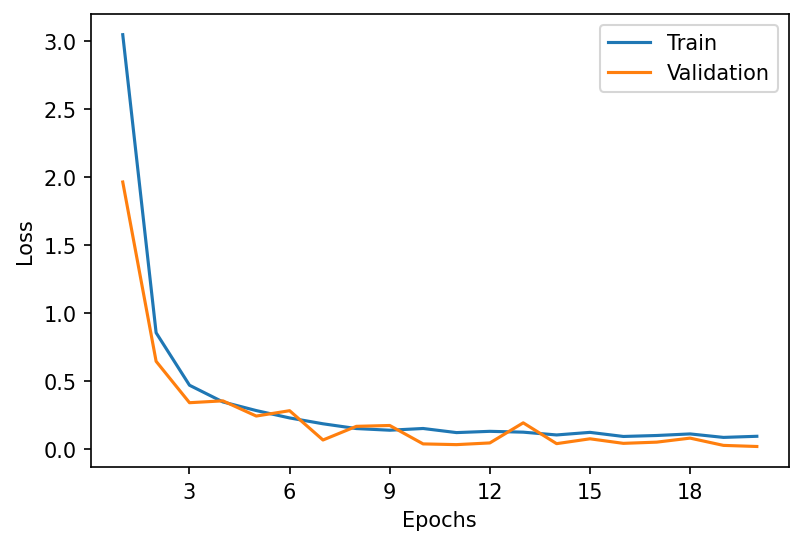

Perte en test 0.0187


In [18]:
input_size = 1
num_layers = 2
hidden_size = 20
n_epoch = 20
batch_size = 100
lr = 0.05

net = RnnLinear(input_size, hidden_size, num_layers,'lstm')
optimizer = optim.SGD(net.parameters(), lr=lr)
criterion = nn.MSELoss()

history = train(net, optimizer, data_train, n_epoch, batch_size, use_gpu=True, criterion=criterion, acc=False)
history.display_loss()
print("Perte en test {:.4f}".format(test(net, data_test, batch_size, criterion=criterion, acc=False)))

Analysons maintenant comment les prédictions du modèle se comparent avec les valeurs attendues.

In [19]:
model = get_model(net, use_gpu=True)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

Pour un exemple du jeu de données d'entraînement:

In [20]:
i = 42
print_sequence(inter_max * x_train[i].squeeze(), inter_max * y_train[i].squeeze())
print("Somme prédite par le modèle: {:.0f}".format(inter_max * y_train_pred[i][0]))

40 + 77 + -61 + -15 + 66 + 37 + 67 + -83 + -79 + -43 = 6
Somme prédite par le modèle: 2


Pour un exemple du jeu de données de test:

In [21]:
i = 42
print_sequence(inter_max * x_test[i].squeeze(), inter_max * y_test[i].squeeze())
print("Somme prédite par le modèle: {:.0f}".format(inter_max * y_test_pred[i][0]))

90 + -56 + 12 + 22 + -31 + -20 + -84 + 54 + -96 + 25 = -84
Somme prédite par le modèle: -79


Il est intéressant de visualiser le comportement du modèle sur l'ensemble des prédictions. Le code suivant compare les valeurs de sommes prédites avec les vraies valeurs de sommes, la diagonale rouge représentant la prédiction exacte souhaitée.

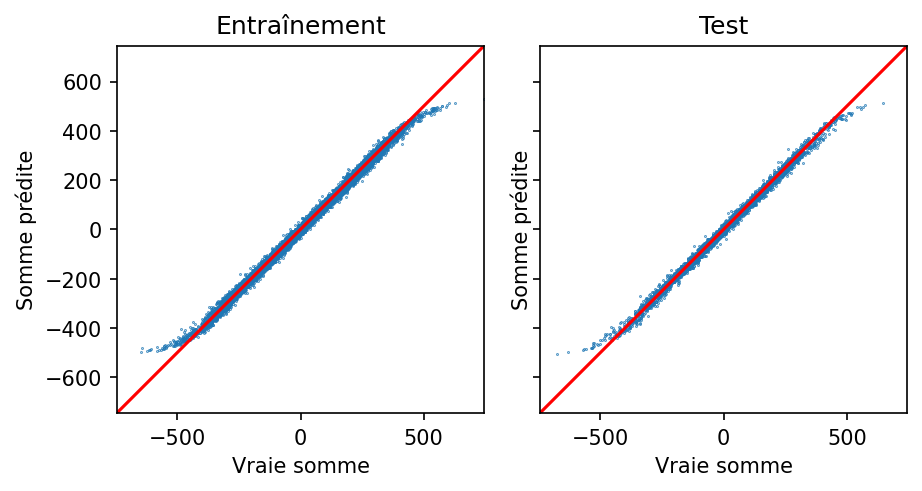

In [22]:
_, axes = plt.subplots(1, 2, sharey=True)
plt.tight_layout()
max_y = inter_max * max(np.abs(y_train).max(), np.abs(y_train_pred).max(), 
                        np.abs(y_test).max(), np.abs(y_test_pred).max())
y_lim = (-max_y, max_y)

titles = ['Entraînement', 'Test']
for i, (y, y_pred) in enumerate([(y_train, y_train_pred), (y_test, y_test_pred)]):
    ax = axes[i]
    ax.set_title(titles[i])
    ax.scatter(inter_max * y, inter_max * y_pred, s=0.1)
    ax.plot(y_lim, y_lim, 'k-', color = 'r')
    ax.set_xlim(y_lim)
    ax.set_ylim(y_lim)
    ax.set_aspect('equal')
    ax.set_xlabel('Vraie somme')
    ax.set_ylabel('Somme prédite')

plt.show()

#### Question
- Qu'observez-vous dans la figure par rapport aux performances du modèle?
    
    **Plusieurs réponses possibles en fonction du modèle appris. Dans notre cas, on observe que le modèle semble moins bien performer pour les exemples avec des sommes aux extrémités des valeurs possibles. En effet, le modèle prédit dans ce cas des valeurs de sommes plus petite en valeur absolue que la vraie somme.**

### Comparaison RNN et LSTM

Effectuez l'entraînement pour ces séries d'hyperparamètres et comparez les performances des modèles RNN et LSTM: 
* N = 30000
* seq_len = 25 
* intervalle = [-10000,10000]
* hidden_size = 50
* number_epoch = 50
* batch_size = 100
* lr = 0.01

Création du jeu de données

In [23]:
torch.manual_seed(42)
N = 30000
seq_len = 25
inter_max = 10000

x, y = build_sum_dataset(N, seq_len, [-inter_max, inter_max])

#  standardisation des données pour faciliter l'apprentissage
x, y = x / inter_max, y / inter_max

# Préparation des données d'entrée. 
x = x[:, :, np.newaxis]
y = y[:, np.newaxis]

data_train = TensorDataset(x[:25000], y[:25000])
data_test = TensorDataset(x[25000:], y[25000:])

Entraînement des modèles

--- RNN ---
Epoch:  1/50 Step: 200/200 100.00% |████████████████████|2.18s loss: 7.557610 val_loss: 4.032796
Epoch:  2/50 Step: 200/200 100.00% |████████████████████|2.17s loss: 3.774146 val_loss: 2.132339
Epoch:  3/50 Step: 200/200 100.00% |████████████████████|2.18s loss: 3.300458 val_loss: 3.742908
Epoch:  4/50 Step: 200/200 100.00% |████████████████████|2.21s loss: 3.493443 val_loss: 1.750029
Epoch:  5/50 Step: 200/200 100.00% |████████████████████|2.17s loss: 3.528342 val_loss: 7.454800
Epoch:  6/50 Step: 200/200 100.00% |████████████████████|2.17s loss: 2.455547 val_loss: 1.244827
Epoch:  7/50 Step: 200/200 100.00% |████████████████████|2.17s loss: 1.745493 val_loss: 0.898970
Epoch:  8/50 Step: 200/200 100.00% |████████████████████|2.16s loss: 1.360211 val_loss: 0.937372
Epoch:  9/50 Step: 200/200 100.00% |████████████████████|2.23s loss: 1.263728 val_loss: 0.798797
Epoch: 10/50 Step: 200/200 100.00% |████████████████████|2.19s loss: 1.055788 val_loss: 0.516743
Epoch: 11/50 Step:

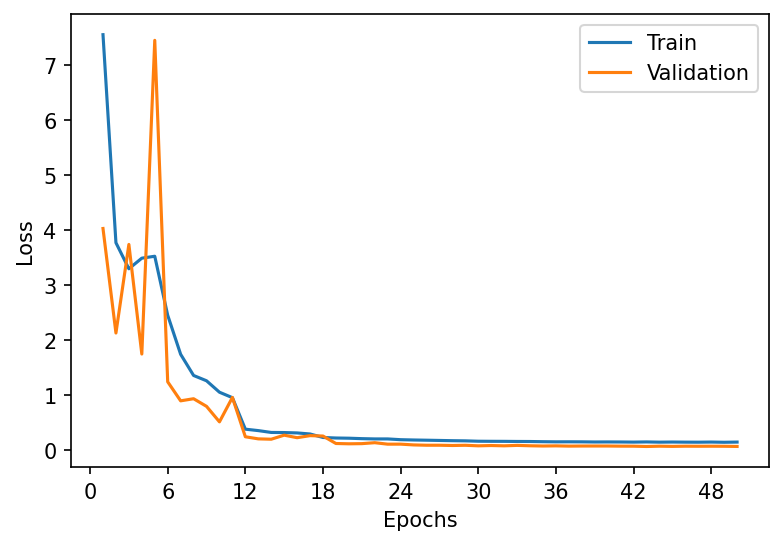

RNN: perte en test 0.0633
--- LSTM ---
Epoch:  1/50 Step: 200/200 100.00% |████████████████████|2.23s loss: 8.365649 val_loss: 8.294603
Epoch:  2/50 Step: 200/200 100.00% |████████████████████|2.24s loss: 8.344794 val_loss: 8.271425
Epoch:  3/50 Step: 200/200 100.00% |████████████████████|2.38s loss: 8.298191 val_loss: 8.181126
Epoch:  4/50 Step: 200/200 100.00% |████████████████████|2.26s loss: 7.368758 val_loss: 3.983567
Epoch:  5/50 Step: 200/200 100.00% |████████████████████|2.29s loss: 2.820730 val_loss: 1.424316
Epoch:  6/50 Step: 200/200 100.00% |████████████████████|2.24s loss: 1.994718 val_loss: 1.257986
Epoch:  7/50 Step: 200/200 100.00% |████████████████████|2.29s loss: 1.332419 val_loss: 0.908884
Epoch     7: reducing learning rate of group 0 to 5.0000e-03.
Epoch:  8/50 Step: 200/200 100.00% |████████████████████|2.29s loss: 0.412883 val_loss: 0.284442
Epoch:  9/50 Step: 200/200 100.00% |████████████████████|2.24s loss: 0.311231 val_loss: 0.203595
Epoch: 10/50 Step: 200/200

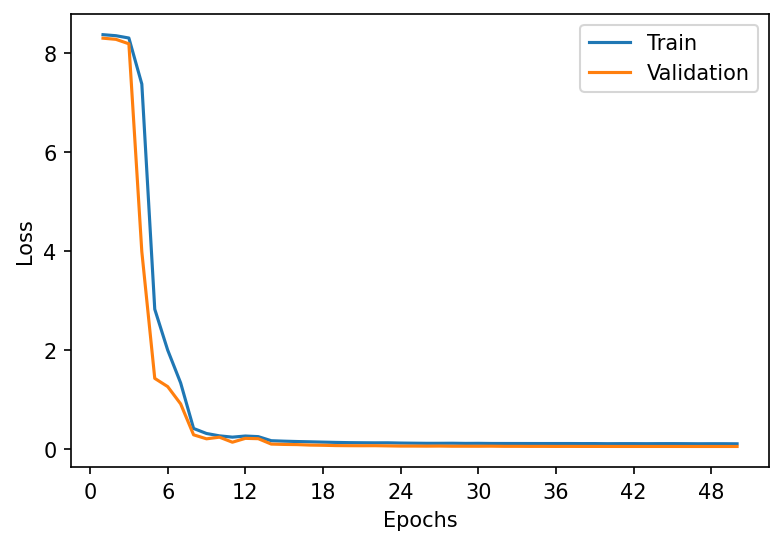

LSTM: perte en test 0.0461


In [24]:
input_size = 1
num_layers = 2
hidden_size = 50
n_epoch = 50
batch_size = 100
lr = 0.01
criterion = nn.MSELoss()

# Entraînement du RNN
print("--- RNN ---")
net_rnn = RnnLinear(input_size, hidden_size, num_layers, 'rnn')
optimizer_rnn = optim.SGD(net_rnn.parameters(), lr=lr)
scheduler = pt.ReduceLROnPlateau(monitor='val_loss', mode='max', patience=5, factor=0.5)

history_rnn = train(net_rnn, optimizer_rnn, data_train, n_epoch, batch_size, use_gpu=True, \
                    callbacks=[scheduler], criterion=criterion, acc=False)
history_rnn.display_loss()
print("RNN: perte en test {:.4f}".format(test(net_rnn, data_test, batch_size, criterion=criterion, acc=False)))

# Entraînement du LSTM
print("--- LSTM ---")
net_lstm = RnnLinear(input_size, hidden_size, num_layers,'lstm')
optimizer_lstm = optim.SGD(net_lstm.parameters(), lr=lr)
scheduler = pt.ReduceLROnPlateau(monitor='val_loss', mode='max', patience=5, factor=0.5)

history_lstm = train(net_lstm, optimizer_lstm, data_train, n_epoch, batch_size, use_gpu=True, \
                     callbacks=[scheduler], criterion=criterion, acc=False)
history_lstm.display_loss()
print("LSTM: perte en test {:.4f}".format(test(net_lstm, data_test, batch_size, criterion=criterion, acc=False)))

#### Question
- Que remarquez vous? Pour aller plus loin, vous pouvez expérimenter avec différentes valeurs d'hyperparamètres et observer les performances résultantes, notamment en fonction de la longeur des séquences.
    
    **Le LSTM semble mieux performer pour résoudre cette tâche d'apprentissage.**